# Linear Correlation Analysis

In [109]:
import pysftp
import os 
import numpy as np
import pandas as pd
import netCDF4
import numpy as np
import helperfuncs

from scipy import io
from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard,data_wizard
from dotenv import load_dotenv   #for python-dotenv method
from datetime import datetime
wizard = data_wizard()
from statsmodels.tsa.api import VAR
pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None)



     


def calculate_mfx(date,d):
    airs_grid = map_grid(grid_size='40', source='airs')
    airs_select_area_indexer = airs_grid.select_area_indexer(min_lat= d['min_lat'],max_lat=d['max_lat'],min_lon=d['min_lon'],max_lon=d['max_lon'])

    file = f'processed_airs_sftp/40_km_grid/30km/mfx/{date}_mfx.npz'
    data = np.load(file, allow_pickle=True)['arr_0']
    cos_lat = np.cos(np.deg2rad(airs_grid.nh_lat))
    data = data * cos_lat

    data = wizard.data_filtering(select_area_indexer = airs_select_area_indexer ,data = data)
    # calculate the mean of the data
    data_mean = np.nanmean(data)
    return data_mean

def calculate_zmzw(date,d):

    era5_grid = map_grid(grid_size=None, source = 'era5_online')
    wizard = data_wizard()
    airs_select_area_indexer = era5_grid.select_area_indexer(min_lat= d['min_lat'],max_lat=d['max_lat'],min_lon=d['min_lon'],max_lon=d['max_lon'])
    data_u = np.load(f'/Users/joaojesus/Desktop/final_year_proj/pre_processed_era5_online/COMPRESSED/WIND_EASTWARD/{date}.npz')['arr_0']
    data_u = wizard.data_filtering(select_area_indexer = airs_select_area_indexer ,data = data_u)

    cos_lat = np.cos(np.deg2rad(era5_grid.lat))
    data = data_u * cos_lat
    # calculate the mean of the data
    data_mean = np.nanmean(data)
    return data_mean

def process(event_date = '2018-02-11'):
    d = {'min_lat': 58,
        'max_lat': 62,
        'min_lon': -180,
        'max_lon': 180}
    ssw_df = pd.read_csv(f'ssw_events_saved_filtered_2/{event_date}_ssw.csv')[['dates','wind_eastward_mean_cos','t_delta']]

    # choose only values where t_delta > 20 and < 0
    ssw_df = ssw_df[(ssw_df['t_delta'] > -45) & (ssw_df['t_delta'] <= 15)]
    # get_day_array = helperfuncs.get_day_array(event_date,20)
    ssw_df['mfx'] = ssw_df['dates'].apply(lambda x: calculate_mfx(x,d))
    ssw_df['zmzw'] = ssw_df['dates'].apply(lambda x: calculate_zmzw(x,d))

    # normalize
    avgs = ssw_df.mean(numeric_only=True)
    devs = ssw_df.std(numeric_only=True)
    ssw_df['ZMZW_normalized'] = ((ssw_df['wind_eastward_mean_cos'] - avgs['wind_eastward_mean_cos']) / devs['wind_eastward_mean_cos']).diff()
    ssw_df['MFX_normlized'] = ((ssw_df['mfx'] - avgs['mfx']) / devs['mfx']).diff()

    return ssw_df



In [110]:
# ssw_df = process(event_date = '2018-02-11')
# ssw_df = ssw_df.interpolate(method ='linear', limit_direction ='forward')
# ssw_df = ssw_df.interpolate(method ='linear', limit_direction ='backward')
# linear_corr_df = ssw_df[['ZMZW_normalized','MFX_normlized']].dropna()
# helperfuncs.correlation_analysis(linear_corr_df)

In [111]:
# import matplotlib.pyplot as plt

# # Plot the data
# fig, ax1 = plt.subplots(figsize=(12, 5))
# line1, = ax1.plot(ssw_df['t_delta'], ssw_df['ZMZW_normalized'], color='blue', label='ZMZW_normalized')
# ax1.set_xlabel('Dates', color='black')
# ax1.tick_params(axis='y', labelcolor='black', which='both', direction='in')
# ax1.grid(axis='both', which='both', linestyle='--', alpha=0.1)
# ax2 = ax1.twinx()
# line2, = ax2.plot(ssw_df['t_delta'], ssw_df['MFX_normlized'], color='orange', label='MFX_normlized')
# ax2.tick_params(axis='y', labelcolor='black', which='both', direction='in')
# ax1.axhline(y=0, color='black', linestyle='dashdot', alpha=0.5)
# plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
# # Increase tick frequency on the y-axis
# ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
# ax2.yaxis.set_major_locator(plt.MaxNLocator(10))
# # add labels boxes
# ax1.set_ylabel('ZMZW normalized', color='blue')
# ax2.set_ylabel('MFX normalized', color='orange')
# plt.show()


In [119]:

# =================================================================================================
# Run VAR for absolute momentum flux for ALL SSW events
# =================================================================================================
files = os.listdir('/Users/joaojesus/Desktop/final_year_proj/ssw_events_saved_filtered_2')
dates = [file[:10] for file in files]
dates.sort()
print(dates)

var = 'MFX_normlized'

main_params_df_auto = pd.DataFrame()
# holdc correlation with var parameters
main_params_df_var = pd.DataFrame()

for date in dates:
    print(date)
    ssw_df = process(event_date = date)
    ssw_df = ssw_df.interpolate(method ='linear', limit_direction ='forward')
    ssw_df = ssw_df.interpolate(method ='linear', limit_direction ='backward')
    dataframe = ssw_df[['ZMZW_normalized','MFX_normlized']].dropna()

    model = VAR(dataframe)
    model_fit = model.fit(maxlags=15)
    
    # =================================================================================================
    # Prep df_params for matrix plots
    # =================================================================================================

    df_params = model_fit.params

    # add name to first column in df_params
    df_params =df_params.reset_index()

    # exclude first row from df_params
    df_params = df_params.iloc[1:]

    standard_error = model_fit.pvalues
    # rename column headers in standard_error
    standard_error = standard_error.reset_index()
    standard_error = standard_error.rename(columns={'ZMZW_normalized':'ZMZW_normalized_se',var:f'{var}_se'})
    standard_error = standard_error.iloc[1:]


    # create a new column with the first two characters of index
    df_params['var'] = df_params['index'].str[:3]

    # create a new column with the the characters after the first two characters of index
    df_params['lag'] = df_params['index'].str[3:]

    df_params['var'] = df_params['var'].apply(lambda x: x.strip('.'))
    df_params['lag'] = df_params['lag'].apply(lambda x: x.strip('.'))

    # select only columns lag where it's equal to wind_eastward_mean_cos
    df_params_auto = df_params[df_params['lag'] == 'ZMZW_normalized']
    
    df_params_var = df_params[df_params['lag'] == var]


    df_params_auto['identifier'] = date

    df_params_var['identifier'] = date


    df_params_auto = pd.merge(df_params_auto, standard_error, on=['index'])

    df_params_var = pd.merge(df_params_var, standard_error, on=['index'])

    # concatenate df_params to main_params_df
    main_params_df_auto = pd.concat([main_params_df_auto, df_params_auto])

    main_params_df_var = pd.concat([main_params_df_var, df_params_var])

['2003-01-17', '2004-01-02', '2006-01-22', '2007-02-22', '2008-02-22', '2009-01-23', '2010-03-21', '2013-01-07', '2018-02-11']
2003-01-17


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2004-01-02


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2006-01-22


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2007-02-22


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2008-02-22


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2009-01-23


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


2010-03-21


ValueError: operands could not be broadcast together with shapes (141,1440) (181,1440) 

In [113]:
main_params_df_var

,index,ZMZW_normalized,MFX_normlized,var,lag,identifier,ZMZW_normalized_se,MFX_normlized_se
0,L1.MFX_normlized,-0.278841,-0.571343,L1,MFX_normlized,2003-01-17,0.130198,0.033766
1,L2.MFX_normlized,-0.133155,-0.533594,L2,MFX_normlized,2003-01-17,0.535362,0.089033
2,L3.MFX_normlized,0.335995,-0.377445,L3,MFX_normlized,2003-01-17,0.131138,0.245634
3,L4.MFX_normlized,0.095765,-0.476639,L4,MFX_normlized,2003-01-17,0.672300,0.149489
4,L5.MFX_normlized,-0.029311,-0.542468,L5,MFX_normlized,2003-01-17,0.901362,0.116326
...,...,...,...,...,...,...,...,...
10,L11.MFX_normlized,0.102824,-0.091836,L11,MFX_normlized,2018-02-11,0.665016,0.791193
11,L12.MFX_normlized,0.041576,-0.133259,L12,MFX_normlized,2018-02-11,0.486468,0.126729
12,L13.MFX_normlized,-0.057548,-0.069951,L13,MFX_normlized,2018-02-11,0.378591,0.463721
13,L14.MFX_normlized,0.003381,-0.101813,L14,MFX_normlized,2018-02-11,0.958128,0.279141


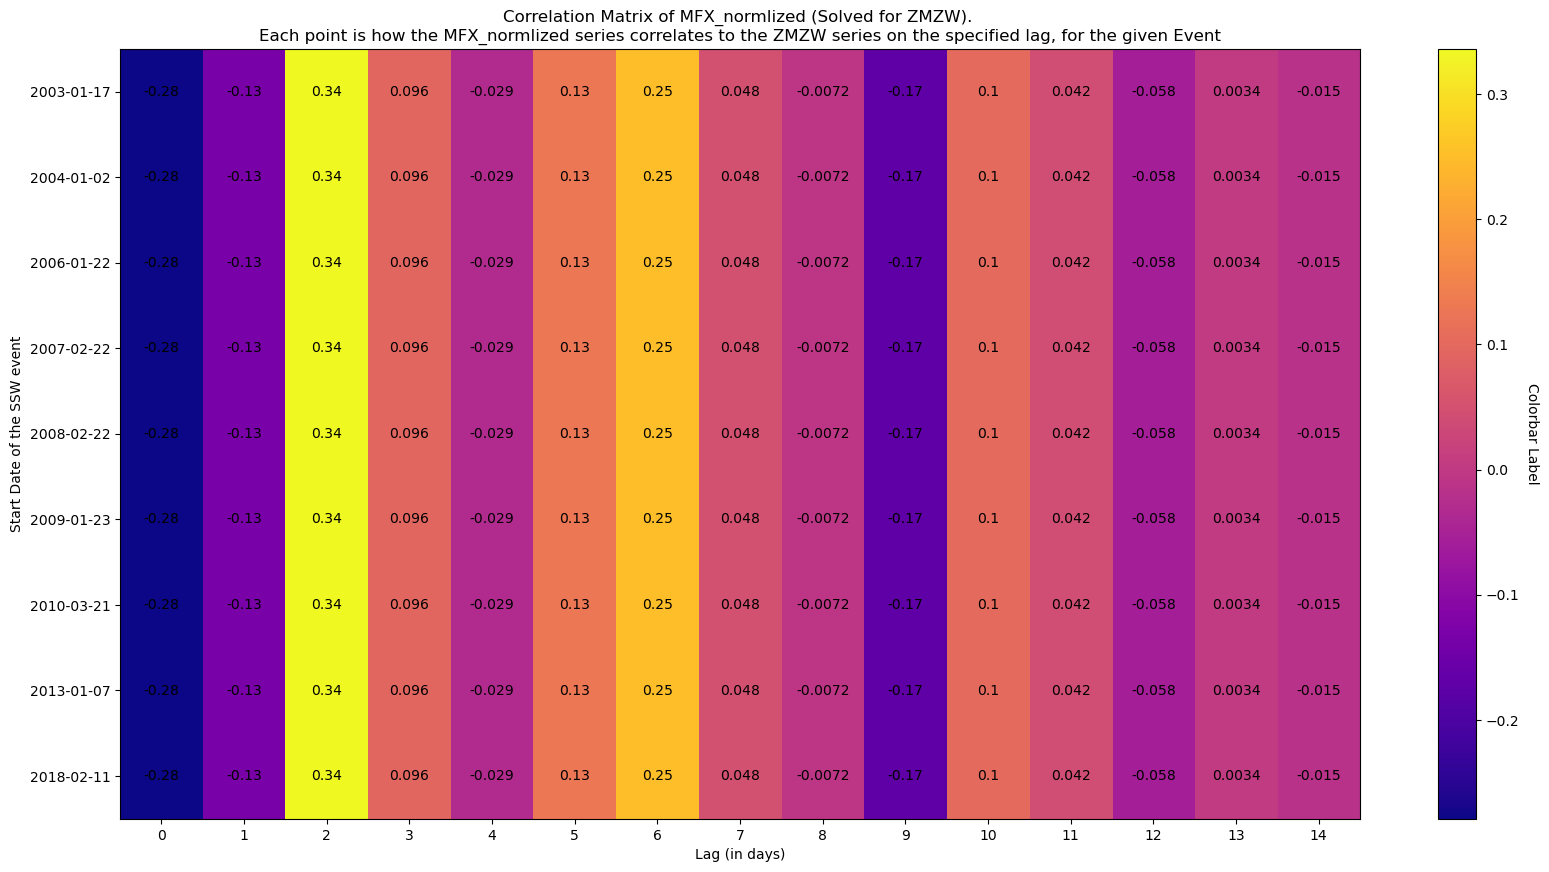

In [116]:
# =================================================================================================
# get correlation coeficients for each identifier
# =================================================================================================
param_df = main_params_df_var

coefs_arr = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr.append(dataframe['ZMZW_normalized'].values)

# =================================================================================================
# get p values for each identifier
# =================================================================================================

coefs_arr_se = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr_se.append(dataframe['ZMZW_normalized_se'].values)
    
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = param_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(coefs_arr, aspect="auto",cmap='plasma')


# add title to the figure
ax.set_title(f"Correlation Matrix of {var} (Solved for ZMZW). \nEach point is how the {var} series correlates to the ZMZW series on the specified lag, for the given Event")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr[i][j]),
                       ha="center", va="center", color="black")

plt.show()

